**The project is based on predction of bitcoin price.**

* Bitcoin being the king of the crypto market drives the market, many coins follow similar pattern as that of bitcoin.

* Advanced crypto traders have their methods to predict the price of bitcoin some of them are finding the resistances, supports, moving averages etc.

* Bitcoin's price data overtime is just a sequence data and **recurrent neural network** has excelled on learning about the sequences, so lets build a recurrent neural network which learn all the trading patterns and predict the price of bitcoin.

**Dataset**
* We will use bitcoin's prior two year candlestick data to train our model.
* We use **Binance API** to fetch the dataset from binance, Binance is one of the largest crypto trading platform to use Binance API we need to create binance account and generate API command.
* We use python-binance package which simplifies the data fetching part.


In [ ]:
# importing libraries
from binance.client import Client
from datetime import datetime
import pandas as pd
import keys

client = Client(api_key = keys.Pkey , api_secret = keys.Skey) # private API command

candles = client.get_klines(symbol = 'LTCUSDT', interval = Client.KLINE_INTERVAL_1HOUR) # just for example we fetch litecoin price in 1h intervals

df = pd.DataFrame(candles) 

In [ ]:
# dataset before preprocessing
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1620842400000,352.94000000,355.13000000,337.80000000,347.09000000,151648.69324000,1620845999999,52394903.37217390,51906,71007.89629000,24538583.30858960,0
1,1620846000000,346.90000000,355.50000000,340.78000000,354.80000000,102324.86873000,1620849599999,35713254.60559370,37250,50712.13479000,17705534.69432920,0
2,1620849600000,354.78000000,358.77000000,351.09000000,356.86000000,61147.56729000,1620853199999,21713218.06773560,20900,30725.02179000,10913445.52928870,0
3,1620853200000,356.89000000,359.99000000,355.00000000,357.01000000,35879.39881000,1620856799999,12810036.57510250,15780,18483.77686000,6599672.93583970,0
4,1620856800000,357.00000000,359.00000000,332.61000000,349.15000000,255747.19972000,1620860399999,87405184.30844650,87282,126449.57273000,43242716.81066080,0


columns are ordered as :

['unix time in ms', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'asset_volume', 'trade_number', 'taker_buy_base', 'taker_by_quote'].

We need to name each column of the dataframe in the order shown above. 

Also the first column is unix time we need to convert it into python date-time object such that it is understandable by us.

In [ ]:
# converting unix time into python-datetime object
date = []
for x in df[0].values :
    date.append(datetime.fromtimestamp(int(x/1000)))

In [ ]:
df_date = pd.DataFrame(date)
df_date.columns = ['date']

In [ ]:
df_date.head()

,date
0,2021-05-12 23:30:00
1,2021-05-13 00:30:00
2,2021-05-13 01:30:00
3,2021-05-13 02:30:00
4,2021-05-13 03:30:00


In [ ]:
df = df.join(df_date)

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.columns = ['open', 'high', 'low', 'close', 'volume', 'close_time', 'asset_volume', 'trade_number', 'taker_buy_base', 'taker_by_quote']
df.head()

,open,high,low,close,volume,close_time,asset_volume,trade_number,taker_buy_base,taker_by_quote
date,,,,,,,,,,
2021-05-12 23:30:00,352.94000000,355.13000000,337.80000000,347.09000000,151648.69324000,1620845999999,52394903.37217390,51906,71007.89629000,24538583.30858960
2021-05-13 00:30:00,346.90000000,355.50000000,340.78000000,354.80000000,102324.86873000,1620849599999,35713254.60559370,37250,50712.13479000,17705534.69432920
2021-05-13 01:30:00,354.78000000,358.77000000,351.09000000,356.86000000,61147.56729000,1620853199999,21713218.06773560,20900,30725.02179000,10913445.52928870
2021-05-13 02:30:00,356.89000000,359.99000000,355.00000000,357.01000000,35879.39881000,1620856799999,12810036.57510250,15780,18483.77686000,6599672.93583970
2021-05-13 03:30:00,357.00000000,359.00000000,332.61000000,349.15000000,255747.19972000,1620860399999,87405184.30844650,87282,126449.57273000,43242716.81066080


### **Now lets do all the things in our custom function name binance_price.**


*   The function has three argumnets **name of the coin**, **time_interval** which controls time_interval of the data fetched, **from_date** which controlls from which date we want to fetch data.

*   The function returns the data frame containing candlestick data with index as the date and time in UTC.

**Preprocessing Done:**

*   Conversion of unix time into python's datetime object.
*   Removed some columns which were unecessary such as trade number etc.
*   After removal we have 5 columns named open, high, low, close, volume.

**Feature Meaning**:

* Open : Open price of the coin(price of the coin when interval started).

* high : highest price attained during that interval.

* low : lowest price attained during that interval.

* close : close price of the coin (price of the coin when interval ended).

* volume : number of coins traded (buy or sold) withn an interval.








In [ ]:
!pip install python-binance
from binance.client import Client
from datetime import datetime
import pandas as pd
import keys
import matplotlib.pyplot as plt
import numpy as np

def binance_price(coin, time_interval, from_date):
    client = Client(api_key = keys.Pkey , api_secret = keys.Skey)
    candles = client.get_historical_klines(coin, time_interval, from_date) # "1 Jun, 2021"
    df = pd.DataFrame(candles)
    date = []
    for x in df[0].values :
        date.append(datetime.fromtimestamp(int(x/1000)))
    
    df = df.iloc[: , 1:6] # keeping necessary columns
    
    df_date = pd.DataFrame(date)
    df_date.columns = ['date'] # adding date columns after conversion.
    
    df = df.join(df_date)
    df.set_index('date', inplace=True)
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df = df.astype('float')
    return df, client

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 184kB 8.6MB/s 
     |████████████████████████████████| 112kB 39.6MB/s 
     |████████████████████████████████| 286kB 37.2MB/s 
     |████████████████████████████████| 1.3MB 26.1MB/s 
     |████████████████████████████████| 296kB 44.1MB/s 
     |████████████████████████████████| 143kB 39.4MB/s 


In [ ]:
df, client = binance_price('BTCUSDT', '4h', '1 Jun, 2017') # prior 4 year data.

KeyboardInterrupt: ignored

In [ ]:
len(df)

8301

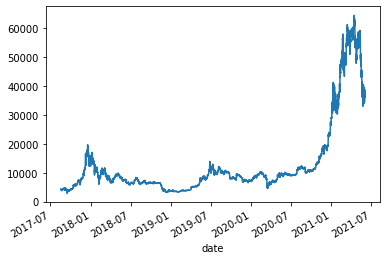

In [ ]:
# Plot of the btc open price overtime
df.open.plot()

In [ ]:
df.tail()

,open,high,low,close,volume
date,,,,,
2021-06-02 16:00:00,38040.69,38200.00,37727.37,37884.57,9291.591592
2021-06-02 20:00:00,37884.58,37929.97,37320.00,37568.68,7443.990253
2021-06-03 00:00:00,37568.68,37903.14,37170.00,37634.57,8381.714112
2021-06-03 04:00:00,37635.24,39039.19,37600.00,38634.09,16294.658537
2021-06-03 08:00:00,38634.77,39420.77,38518.96,39318.51,7857.589835


We need to scale features as features have **different ranges**, if not done our model training will be instable and slow.

We use sklearn's **MinMaxScaler** for the scaling operation.

In [ ]:
# We need to scale features as features have different ranges, if not done our model training will be instable and slow.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1 = scaler.fit_transform(df)

Now we need to prepare the dataset in a some sequence.

We call 60 consecutive rows in our dataset as the an input istance and just next row's open price as the output for the sequence (here sequence has 60 time steps.)

So example, X1 (first training instance) has first 60 rows of the dataset and 61th row's open column as y1.

Note each timestep has five features.

The below code-cell does the same.

In [ ]:
# Code to generate the dataset 
# we are excuding last 30 time steps of the dataset as we will use it for cross-validation

X_train = []
y_train = []
time_step = 60

for i in range(len(df1) - 30 - time_step):
    X_train.append(df1[i : i + time_step])
    y_train.append(df1[i + time_step][0])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# X_train = []
# y_train = []
# time_step = 60

# for i in range(len(df1) -  time_step):
#     X_train.append(df1[i : i + time_step])
#     y_train.append(df1[i + time_step][0])
    
# X_train = np.array(X_train)
# y_train = np.array(y_train)

# X_test = np.array(df1[len(df1) - time_step : len(df1)]).reshape(1, time_step, 5)


In [ ]:
X_train.shape

(8241, 60, 5)

In [ ]:
# Generating the test set which contains last 30 instances for cross-validation

X_test = []
y_test = []

for i in range(len(df1)-30-time_step, len(df1)-time_step) :
    X_test.append(df1[i : i + time_step])
    y_test.append(df1[i + time_step][0])
    
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
X_test.shape

(1, 60, 5)

We use **Stacked LSTM** network.

1. The first layer is LSTM layer with **64 units and return_sequences = True** 
 (means it will return the sequence not only the last timestep's output).

  For using stacked LSTM we need to set return_sequences = True, to preserve the sequence orientation of data.

2. **Dropout layer** to prevent overfitting with dropout rate equal to 0.2.

3. The third layer is LSTM layer with **64 units** and return_sequnces = True.
 
4. Dropout layer with rate = 0.2.

5. The fifth layer is LSTM layer with **32 units** and return_sequences = True.

6. Dropout layer with rate = 0.2.

7. The seventh layer is a LSTM layer with **32 units**.

8. Dropout layer with rate = 0.2.

9. The last layer is a **Dense layer with no activation** as it is an regression problem.





In [ ]:
import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Sequential, Model

def build_model():
    model = Sequential([
        LSTM(64, return_sequences = True, input_shape = X_train[0].shape),
        Dropout(0.2),
        
        LSTM(64, return_sequences = True),
        Dropout(0.2),
        
        LSTM(32,  return_sequences = True),
        Dropout(0.2),
        
        LSTM(32),
        Dropout(0.2),
        
        Dense(1)
    ])
    
    model.compile(optimizer = 'adam', loss = 'mse')
    model.summary()
    return model

In [ ]:
model = build_model()


In [ ]:
# import keras
# model = keras.models.load_model('/content/btc_model.h5')

In [ ]:
# training the model
hist = model.fit(X_train, y_train, epochs = 50, batch_size = 128)

Epoch 1/50
65/65 [==============================] - 8s 61ms/step - loss: 4.6181e-04
Epoch 2/50
65/65 [==============================] - 4s 61ms/step - loss: 4.2396e-04
Epoch 3/50
65/65 [==============================] - 4s 62ms/step - loss: 4.2139e-04
Epoch 4/50
65/65 [==============================] - 4s 61ms/step - loss: 4.1087e-04
Epoch 5/50
65/65 [==============================] - 4s 61ms/step - loss: 4.2265e-04
Epoch 6/50
65/65 [==============================] - 4s 61ms/step - loss: 4.4944e-04
Epoch 7/50
65/65 [==============================] - 4s 61ms/step - loss: 4.2764e-04
Epoch 8/50
65/65 [==============================] - 4s 62ms/step - loss: 4.3739e-04
Epoch 9/50
65/65 [==============================] - 4s 62ms/step - loss: 4.3258e-04
Epoch 10/50
65/65 [==============================] - 4s 61ms/step - loss: 4.3378e-04
Epoch 11/50
65/65 [==============================] - 4s 61ms/step - loss: 4.3724e-04
Epoch 12/50
65/65 [==============================] - 4s 61ms/step - loss: 

In [ ]:
model.save('btc_model.h5')

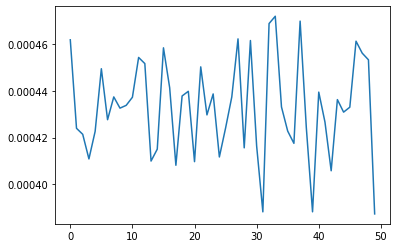

In [ ]:
plt.plot(model.history.history['loss'], label = 'loss')

Text(0.5, 1.0, 'BTC')

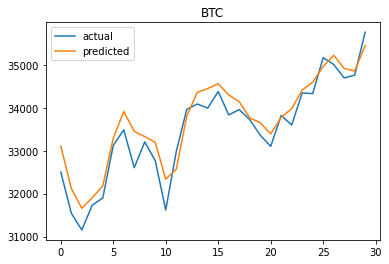

In [ ]:
# plot of actual and predicted price

y_pred = model.predict(X_test)
plt.plot(y_test/scaler.scale_[0], label = 'actual')
plt.plot(y_pred/scaler.scale_[0], label = 'predicted')
plt.legend()
plt.title('BTC')

In [ ]:
# plt.plot(model.predict(X_train[-30: ])/scaler.scale_[0])

In [ ]:
y_pred = model.predict(X_test)/scaler.scale_[0]
y_pred

array([[36596.723]], dtype=float32)

In [ ]:
df.tail()

,open,high,low,close,volume
date,,,,,
2021-06-02 16:00:00,38040.69,38200.00,37727.37,37884.57,9291.591592
2021-06-02 20:00:00,37884.58,37929.97,37320.00,37568.68,7443.990253
2021-06-03 00:00:00,37568.68,37903.14,37170.00,37634.57,8381.714112
2021-06-03 04:00:00,37635.24,39039.19,37600.00,38634.09,16294.658537
2021-06-03 08:00:00,38634.77,39420.77,38518.96,39318.51,7857.589835


In [ ]:
per_change = 100 * (model.predict(X_test) - model.predict(X_train[-1 : ]))/model.predict(X_train[-1 : ])

In [ ]:
per_change

array([[1.9172245]], dtype=float32)